# InstructPix2Pix の実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/5-3-2_instruct-pix2pix.ipynb)

参考: https://github.com/huggingface/notebooks/blob/main/diffusers/InstructPix2Pix_using_diffusers.ipynb

## 準備

In [1]:
!pip install -qq py-img-gen

In [2]:
import warnings

import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
seed = 19950815

warnings.simplefilter("ignore", FutureWarning)

## 編集対象画像の読み込み

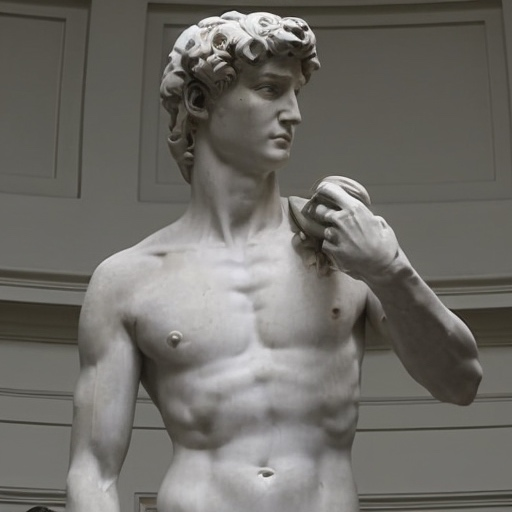

In [3]:
from diffusers.utils import load_image

original_image = load_image(
    "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
)
original_image

## InstructPix2Pix 用のパイプラインの読み込み

In [4]:
from diffusers import StableDiffusionInstructPix2PixPipeline

model_id = "timbrooks/instruct-pix2pix"

pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    variant="fp16",
    safety_checker=None,  # NSFW 用のフィルターを今回は無効化
)

pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## テキスト指示によるオリジナル画像の編集

  0%|          | 0/30 [00:00<?, ?it/s]

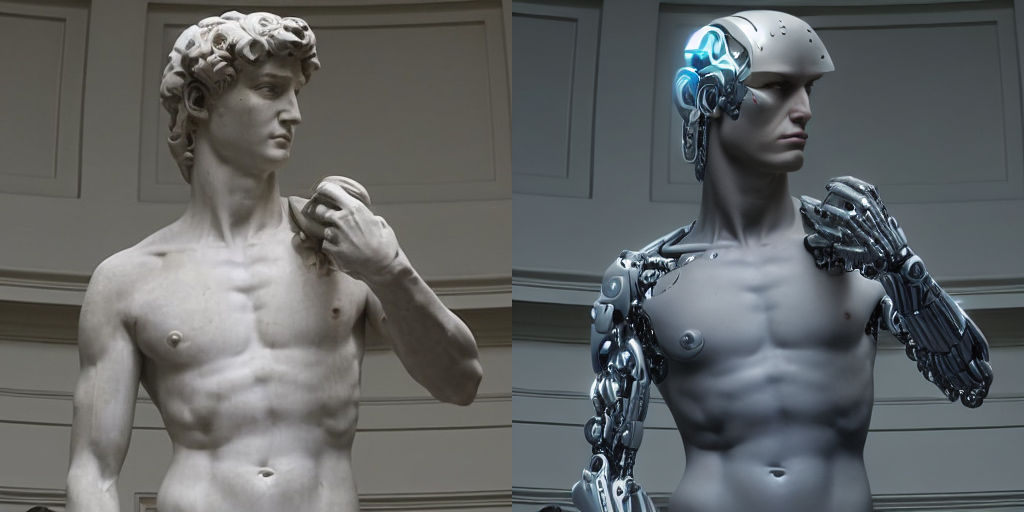

In [5]:
from diffusers.utils import make_image_grid

edit_instruction = "turn him into cyborg"

edited_image = pipe(
    prompt=edit_instruction,
    image=original_image,
    num_inference_steps=30,
    image_guidance_scale=1,
    generator=torch.manual_seed(seed),
).images[0]

images = [original_image, edited_image]
make_image_grid(images, rows=1, cols=2)

## InstructPix2Pix のハイパーパラメータの影響度合いの調査

### 可視化用の関数の定義

In [6]:
from PIL.Image import Image as PilImage


def generate_image(
    s_T: float, s_I: float, seed: int
) -> PilImage:
    output = pipe(
        prompt=edit_instruction,
        image=original_image,
        num_inference_steps=30,
        guidance_scale=s_T,
        image_guidance_scale=s_I,
        generator=torch.manual_seed(seed),
    )
    images = output.images
    return images[0]

### 各ハイパーパラメータにおける編集結果の取得

In [7]:
import itertools

s_T_list, s_I_list = [3, 7.5, 15], [1.0, 1.2, 1.6]
combinations = list(itertools.product(s_I_list, s_T_list))

images = [
    generate_image(s_T=s_T, s_I=s_I, seed=seed)
    for s_I, s_T in combinations
]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

### 取得した編集結果の可視化

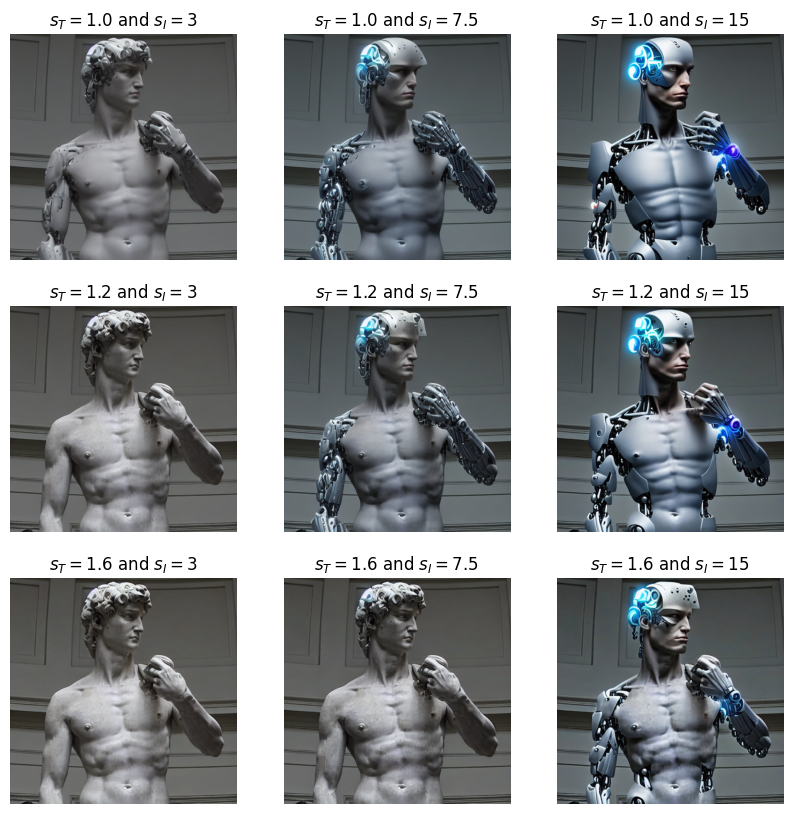

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))

for i, ((s_T, s_I), image) in enumerate(
    zip(combinations, images)
):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(image)
    ax.set_title(f"$s_T = {s_T}$ and $s_I = {s_I}$")
    ax.axis("off")